In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/agents-intensive-capstone-project/Hackathon dataset.txt
/kaggle/input/council-policy/chelsea.pdf
/kaggle/input/council-policy/redbridge.pdf
/kaggle/input/council-policy-1/hammersmith_and_fullham.pdf
/kaggle/input/house-prices/house_pricing.xlsx


In [3]:
!pip install -Uq "google-genai==1.7.0"
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'
!pip install chromadb
!pip install fitz
!pip install mcp mcp-server

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 7.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.18.0 requires google-genai<2.0.0,>=1.45.0, but you have google-genai 1.7.0 which is incompatible.
google-cloud-aiplatform 1.125.0 requires google-genai<2.0.0,>=1.37.0, but you have google-genai 1.7.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [87]:
from google import genai
from google.genai import types

from IPython.display import Markdown, display

genai.__version__

'1.48.0'

In [88]:
from kaggle_secrets import UserSecretsClient

client = genai.Client(api_key=UserSecretsClient().get_secret("GOOGLE_API_KEY"))

In [89]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

### Session/Memory and States definitions

In [90]:
from typing import Optional, Dict
from pydantic import BaseModel

class State(BaseModel):
    postcode: str
    policy: Optional[Dict] = None
    housing: Optional[Dict] = None
    transport: Optional[Dict] = None
    community: Optional[Dict] = None
    crime: Optional[Dict] = None
    summary: Optional[str] = None
    housing_data: Optional[Dict] = None  # raw housing info from Excel
    mean_income: Optional[float] = None  # mean household income
    affordability: Optional[float] = None  # metric = house price / income


In [161]:
class SessionMemory:
    """
    Simple in-memory session store keyed by session_id.
    Stores State objects for the duration of the session.
    """
    def __init__(self):
        self.sessions = {}

    def save(self, session_id: str, state: State):
        self.sessions[session_id] = state

    def load(self, session_id: str) -> State:
        return self.sessions.get(session_id)

    def exists(self, session_id: str) -> bool:
        return session_id in self.sessions


### Custom Helper functions/tools

In [181]:
import re
import requests

def income_api(postcode: str):
    url = f"https://crystalroof.co.uk/customer-api/income/mean-household-income/postcode/v1/W60WW?api_key=DEMO"
    resp = requests.get(url, timeout=10)
    if resp.status_code != 200:
        return None
    return resp.json()['data']['totalMeanAnnualIncome'] # contains mean household income

def crime_api_tool(postcode: str):
    url = f"https://crystalroof.co.uk/customer-api/crime/crime-rate/postcode/v1/W60WW?api_key=DEMO"
    response = requests.get(url, timeout=10)

    if response.status_code != 200:
        return {"error": "Postcode not found or API offline"}

    return response.json()


In [195]:
from google.genai import types

def search_google(query: str) -> dict:
    # 1. Configure grounding
    config_with_search = types.GenerateContentConfig(
        tools=[types.Tool(google_search=types.GoogleSearch())],
    )

    # 2. Helper to query search-grounded model
    def query_with_grounding():
        response = client.models.generate_content(
            model="gemini-2.0-flash",
            contents=query,
            config=config_with_search
        )
        return response.candidates[0]

    # 3. Retry until grounding chunks exist
    rc = query_with_grounding()
    while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
        rc = query_with_grounding()

    # 4. Extract grounded search results
    chunks = rc.grounding_metadata.grounding_chunks
    sources = []
    for chunk in chunks:
        title = chunk.web.title or "Unknown"
        url = chunk.web.uri or ""
        sources.append(f"{title}: {url}")
    return sources


In [230]:
import pandas as pd

def load_excel(path="/kaggle/input/house-prices/house_pricing.xlsx"):
    xls = pd.ExcelFile(path)
    sheets = xls.sheet_names[1:]  # drop first sheet
    return xls, sheets

def flatten_columns(df):
    """Flatten multi-index columns and remove 'Unnamed' entries."""
    df.columns = ["_".join([str(c) for c in col if str(c) != "nan"]) for col in df.columns]
    return df.loc[:, ~df.columns.str.contains("Unnamed")]

def parse_sheet_by_house_type(df):
    # Keep only the first 5 columns (Year, Month + London 4 house types)
    df = df.iloc[:, :5]
    
    # Fill down the year for month rows
    df.iloc[:, 0] = df.iloc[:, 0].ffill()
    
    # Filter rows for 2025
    london_2025 = df[df.iloc[:, 0] == 2025].reset_index(drop=True)
    london_2025.columns = ['Year', 'Month', 'Detached', 'Semi Detached', 'Terraced', 'Flat'][:len(london_2025.columns)]
    return london_2025

def parse_average_type(df):
    # Remove the last 15 columns
    df = df.iloc[:, :-15]
    # Melt so each Borough becomes a row
    borough_prices = df.melt(id_vars=[df.columns[0]], var_name='Borough', value_name='Average Price')
    borough_prices = borough_prices[borough_prices[df.columns[0]].astype(str).str.contains('25')].reset_index(drop=True)
    borough_prices.columns = ['Year_Month', 'Borough', 'Average Price']
    return borough_prices
    
def parse_sales_volume(df):
    # Remove the last 15 columns
    df = df.iloc[:, :-15]
    # Melt so each Borough becomes a row
    sales_volumes = df.melt(id_vars=[df.columns[0]], var_name='Borough', value_name='Average Price')
    sales_volumes = sales_volumes[sales_volumes[df.columns[0]].astype(str).str.contains('25')].reset_index(drop=True)
    sales_volumes.columns = ['Year_Month', 'Borough', 'Sales Volume']
    return sales_volumes

def parse_excel(path="/kaggle/input/house-prices/house_pricing.xlsx", borough='H_a_m_m_e_r_s_m_i_t_h_ _&_ _F_u_l_h_a_m'):
    xls, sheets = load_excel(path)
    london_2025 = None
    borough_prices = None
    sales_volumes = None
    for sheet in sheets:
        df = pd.read_excel(xls, sheet_name=sheet)
        df = flatten_columns(df)
        if sheet =='By type':
            london_2025 = parse_sheet_by_house_type(df)
        if sheet =='Average price':
            borough_prices = parse_average_type(df)
        if sheet =='Sales Volume':
            sales_volumes = parse_sales_volume(df)
    if borough_prices is not None and sales_volumes is not None:
        borough_data = pd.merge(borough_prices, sales_volumes, on=['Year_Month', 'Borough'], how='outer')
    else:
        borough_data = borough_prices if borough_prices is not None else sales_volumes
    # only select data for the specified borough
    if borough_data is not None:
        borough_data = borough_data[borough_data['Borough'] == borough].reset_index(drop=True)
    return london_2025, borough_data

def calculate_affordability_metric(mean_income, borough_data):
    """
    Always returns a 3-tuple: (avg_house_price, affordability_metric, latest_row)
    """
    latest_row = None
    avg_house_price = None
    affordability_metric = None

    if borough_data is not None and not borough_data.empty:
        latest_row = borough_data.iloc[-1]

        avg_house_price = latest_row["Average Price"]
        if hasattr(avg_house_price, "text"):
            try:
                avg_house_price = float(avg_house_price.text)
            except:
                avg_house_price = None
        else:
            avg_house_price = float(avg_house_price)

        if avg_house_price is not None and mean_income is not None:
            affordability_metric = avg_house_price / mean_income

    return avg_house_price, affordability_metric, latest_row



### Validating postcode

In [210]:
def validate_postcode(state: State):
    postcode = state.postcode.strip().upper()
    pattern = r"^[A-Z]{1,2}\d[A-Z\d]?\s?\d[A-Z]{2}$"
    valid = re.match(pattern, postcode) is not None
    if not valid:
        raise Exception("Invalid postcode")
    return state

### Crime API agent

In [211]:
def crime_and_safety_agent(state: State) -> State:
    crime_data = crime_api_tool(state.postcode)

    if not crime_data or "data" not in crime_data:
        state.crime = {
            "summary": f"No crime data available for {state.postcode}.",
            "data": crime_data
        }
        return state

    rate = crime_data["data"].get("rate", {})
    rank = crime_data["data"].get("rank", {})

    prompt = f"""
You are a friendly assistant. Summarize the following crime data for postcode {state.postcode} in a concise, readable paragraph suitable for a public report. Include total crime rate, top 3 crime categories by value, and safety ranking.

Crime Rate Data:
{rate}

Crime Rank Data:
{rank}

Return the summary as natural language text.
"""

    # ✅ Use the client instance
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt
    )

    natural_text_summary = response.text.strip()

    state.crime = {
        "data": crime_data.get("data"),
        "summary": natural_text_summary
    }

    return state


### Policy RAG agent

In [222]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry
import chromadb # this is a embedding function that sets up the database collection 
from google.genai import types
from pypdf import PdfReader

def load_pdf(path):
    reader = PdfReader(path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() or ""
    return text

pdf1 = load_pdf("/kaggle/input/council-policy-1/hammersmith_and_fullham.pdf")

def chunk(text, size=1500):
    words = text.split()
    return [" ".join(words[i:i+size]) for i in range(0, len(words), size)]

documents = chunk(pdf1)

class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"
        print(self.document_mode)
        response = client.models.embed_content( 
            # embed_content takes the contents and converts into a vector rep and stores into a chroma (database)
            model="models/text-embedding-004",
            contents=input, # this is the document
            config=types.EmbedContentConfig(
                task_type=embedding_task, # tells u how the embedding should be created, 
                # so gemini will make embeddings optimised for either storing in database or searching against it
            ),
        )
        return [e.values for e in response.embeddings]

DB_NAME = "policy_agent_db"
embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True # embedding documents first

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)
db.add(documents=documents, ids=[f"doc_{i}" for i in range(len(documents))])
print(db)

/tmp/ipykernel_47/3494482782.py:45: DeprecationWarning: The class GeminiEmbeddingFunction does not implement __init__. This will be required in a future version.
  embed_fn = GeminiEmbeddingFunction()


True


[12/01/25 02:44:19] INFO     HTTP Request: POST                                                     ]8;id=762958;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=853509;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/text-embedding                
                             -004:batchEmbedContents "HTTP/1.1 200 OK"                                             

Collection(name=policy_agent_db)


In [248]:
def policy_agent(state: State) -> State:
    """
    Fetches local policy info and returns it as structured Markdown.
    """

    if getattr(state, "policy", None):
        return state

    embed_fn.document_mode = False  # query mode

    question = (
        f"What planning, zoning, waste, licensing and land-use rules "
        f"apply to the area around postcode {state.postcode}?"
    )

    # Retrieve top 5 chunks
    results = db.query(
        query_texts=[question],
        n_results=5
    )

    retrieved_chunks = results["documents"][0]
    # Wrap chunks as Markdown bullet points
    context_md = "\n".join([f"- {chunk}" for chunk in retrieved_chunks])

    prompt = f"""
You are CIVAI's Policy RAG Agent.

Using ONLY the context below, extract all relevant policy information for the target postcode area.

**User question:**
"{question}"

**Context from official policy documents:**
{context_md}

Return a **Markdown summary** with the following sections, using headings and bullets:

## 📌 Zoning Rules
## 🏗️ Planning Permissions
## ♻️ Waste & Recycling
## 📝 Licensing Rules
## 🌳 Land Use Restrictions
## 🏛️ Administrative / Authority Rules

Make sure:
- Each section has at least 2-3 bullet points if info exists
- Headings are `##` for each main section
- Bullets start with `-`
- No extra text outside Markdown
"""

    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt
    )

    # Store Markdown directly in state
    state.policy = {
        "context_used": context_md,
        "summary": response.text  # Markdown-ready
    }

    return state


### Housing agent

A common metric is:

$$
\text{Affordability} \;=\; \frac{\text{House Price}}{\text{Mean Household Income}}
$$

- Lower values → more affordable.  
- Higher values → less affordable.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


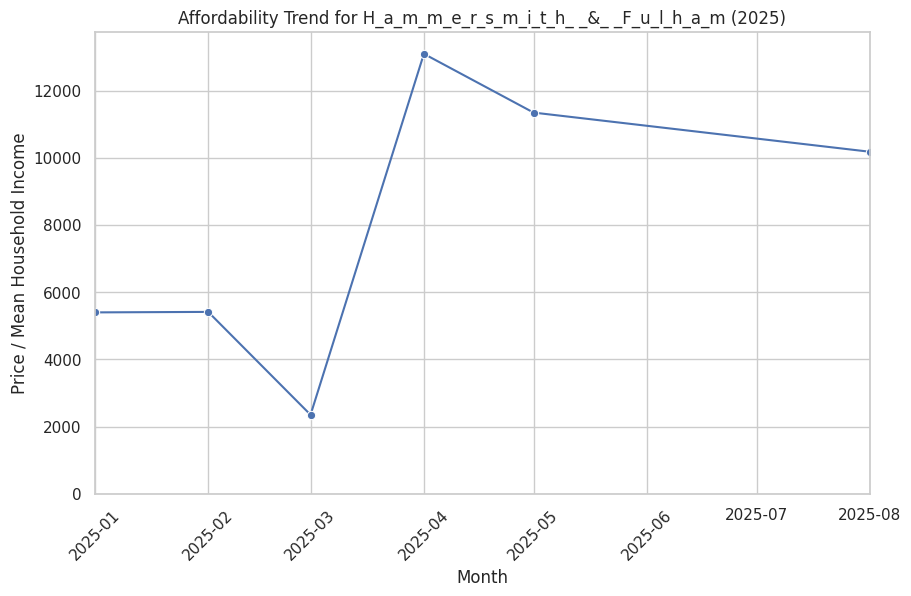

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# # --- Run ---
london_2025, borough_data = parse_excel()

sns.set(style="whitegrid")
plt.figure(figsize=(10,6))

# Create 'Affordability' column if it doesn't exist
borough_data['Affordability'] = borough_data['Average Price'] / borough_data['Sales Volume']

# Ensure 'Year_Month' is datetime
borough_data['Year_Month'] = pd.to_datetime(borough_data['Year_Month'], errors='coerce')

# Filter data to include only 2025
borough_2025 = borough_data[borough_data['Year_Month'].dt.year == 2025]

# Histogram of affordability
sns.histplot(data=borough_2025, x='Affordability')

# Line plot of affordability trend
sns.lineplot(data=borough_2025, x='Year_Month', y='Affordability', marker='o')
plt.xticks(rotation=45)
plt.title(f'Affordability Trend for {borough_2025["Borough"].iloc[0]} (2025)')
plt.ylabel('Price / Mean Household Income')
plt.xlabel('Month')

# Optional: set x-limits to the actual min/max of 2025 months
plt.xlim(borough_2025['Year_Month'].min(), borough_2025['Year_Month'].max())

plt.show()


In [241]:
def housing_agent(state: State) -> State:
    """Generate a natural language housing summary with affordability."""
    if getattr(state, "housing_data", None):
        return state
    postcode = state.postcode
    borough = "H_a_m_m_e_r_s_m_i_t_h_ _&_ _F_u_l_h_a_m"  # or map postcode->borough

    london_2025, borough_data = parse_excel()
    mean_income = income_api(state.postcode)
    avg_house_price, affordability_metric, latest_row = calculate_affordability_metric(mean_income, borough_data)

    state.housing_data = {
        "avg_price": avg_house_price,
        "borough": borough,
        "month": latest_row["Year_Month"] if latest_row is not None else None
    }
    state.mean_income = mean_income
    state.affordability = affordability_metric

    afford_str = f"{affordability_metric:.2f}" if affordability_metric is not None else "N/A"
    avg_price_str = f"£{avg_house_price}" if avg_house_price is not None else "N/A"
    income_str = f"£{mean_income}" if mean_income is not None else "N/A"
    
    prompt = f"""
    You are a housing assistant. 
    
    Provide a concise summary for postcode {postcode}:
    
    - Average house price: {avg_price_str}
    - Mean household income: {income_str}
    - Affordability metric (price / income): {afford_str}
    
    Explain if housing is affordable, moderately expensive, or expensive. 
    Make it readable for a general user in 3-4 sentences.
    """


    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt
    )

    state.housing = {
        "avg_price": avg_house_price,
        "mean_income": mean_income,
        "affordability": affordability_metric,
        "summary": response.text
    }

    return state


### Transport 

In [242]:
from typing import Dict, Optional
from google.genai import types
from IPython.display import Markdown

def transport_agent(state: State) -> State:
    """
    Fetch transport & commute information for a given postcode
    using Google Search grounding and generate a natural language summary.
    """
    postcode = state.postcode
    
    if not postcode:
        state.transport = {"summary": "No postcode provided."}
        return state

    query = f"Transport options, commute times, walkability near {postcode} London"

    # --- 1. Configure search grounding ---
    config_with_search = types.GenerateContentConfig(
        tools=[types.Tool(google_search=types.GoogleSearch())],
    )

    # --- 2. Helper function to query LLM with grounding ---
    def query_with_grounding():
        response = client.models.generate_content(
            model='gemini-2.0-flash',
            contents=query,
            config=config_with_search
        )
        # Return first candidate for simplicity
        return response.candidates[0]

    # --- 3. Retry loop until grounding chunks exist ---
    rc = query_with_grounding()
    while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
        rc = query_with_grounding()

    # --- 4. Extract grounded search chunks ---
    chunks = rc.grounding_metadata.grounding_chunks
    text_to_summarize = "\n".join([f"{chunk.web.title}: {chunk.web.uri}" for chunk in chunks])

    # --- 5. Summarize with LLM ---
    summary_prompt = f"""
    You are a transport assistant.
    Summarise the transport options and commute information for postcode {postcode} in London.
    
    Include:
    - Nearby Tube/rail/bus stations
    - Average commute time to Central London
    - Walkability or cycling options
    
    Provide a concise, user-friendly summary in 3-4 sentences.
    
    Use the following sources to guide your summary:
    {text_to_summarize}
    """

    summary_response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=summary_prompt
    )

    # --- 6. Save structured + summary in state ---
    state.transport = {
        "query": query,
        "sources": text_to_summarize,
        "summary": summary_response.text
    }

    return state


### Community Agent

In [260]:
def community_agent(state: State) -> State:
    """
    Fetches community + amenities info around a postcode using Google Search grounding.
    Includes: parks, schools, masjids, churches, shops, restaurants, walkability.
    Produces a natural-language summary.
    """

    postcode = state.postcode

    if not postcode:
        state.community = {"summary": "No postcode provided."}
        return state

    query = f"Community amenities near {postcode} London: parks, schools, mosques, churches, shops, restaurants, walkability, family friendliness"

    sources = search_google(query)
    text_to_summarize = "\n".join(sources)

    # 5. Summarise community information
    summary_prompt = f"""
    You are a community-living expert.

    Summarise key community and lifestyle features around postcode {postcode}.

    Include:
    - Local parks and green spaces
    - Primary & secondary schools (mention Ofsted if known)
    - Mosques, churches and major places of worship
    - Nearby shops, supermarkets, cafés and restaurants
    - Walkability, safety for families, general community vibe
    - Analyse green space, air quality, walkability

    Be concise and friendly (3–5 sentences).
    Use ONLY the following search-grounded sources:

    {text_to_summarize}
    """

    summary_response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=summary_prompt
    )

    # 6. Store results in the state
    state.community = {
        "query": query,
        "sources": text_to_summarize,
        "summary": summary_response.text
    }

    return state


### Summary agent

In [244]:
def summary_agent(state: State) -> State:
    """
    Builds a polished, well-structured Markdown report summarising
    the outputs of all other agents. The result is designed to look
    clean both in Markdown and when converted to PDF.
    """

    postcode = getattr(state, "postcode", "Unknown")

    sections = []

    # Crime & Safety
    if getattr(state, "crime", None) and state.crime.get("summary"):
        sections.append(
            f"""
## 🔒 Crime & Safety

{state.crime['summary']}
"""
        )

    # Housing
    if getattr(state, "housing", None) and state.housing.get("summary"):
        sections.append(
            f"""
## 🏠 Housing Overview

{state.housing['summary']}
"""
        )

    # Transport
    if getattr(state, "transport", None) and state.transport.get("summary"):
        sections.append(
            f"""
## 🚆 Transport & Connectivity

{state.transport['summary']}
"""
        )

    # Community
    if getattr(state, "community", None) and state.community.get("summary"):
        sections.append(
            f"""
## 🏘️ Community & Local Amenities

{state.community['summary']}
"""
        )

    # Policy / Regulations
    if getattr(state, "policy", None) and state.policy.get("summary"):
        sections.append(
            f"""
## 📜 Local Policies & Regulations

{state.policy['summary']}
"""
        )

    # Final assembled report
    report = f"""
# 🏙️ CIVAI Intelligence Report
### Postcode: **{postcode}**

---

{''.join(sections)}

---

### 🧾 Report Generated Automatically by CIVAI
"""

    state.summary = report.strip()
    return state


### Orchestrator agent

In [245]:
from langgraph.graph import StateGraph, END

graph = StateGraph(State)

graph.add_node("validate", validate_postcode)
graph.add_node("policy_info", policy_agent)
graph.add_node("crime_safety", crime_and_safety_agent)
graph.add_node("housing_info", housing_agent)
graph.add_node("transport_info", transport_agent)
graph.add_node("community_info", community_agent)
graph.add_node("build_summary", summary_agent)

graph.set_entry_point("validate")

# Run all agents independently after validation
graph.add_edge("validate", "policy_info")
graph.add_edge("validate", "housing_info")
graph.add_edge("validate", "crime_safety")
graph.add_edge("validate", "transport_info")
graph.add_edge("validate", "community_info")

# Then summary collects everything
graph.add_edge("policy_info", "build_summary")
graph.add_edge("housing_info", "build_summary")
graph.add_edge("transport_info", "build_summary")
graph.add_edge("community_info", "build_summary")
graph.add_edge("crime_safety", "build_summary")

graph.add_edge("build_summary", END)

app = graph.compile()
print(app)


In [252]:
import asyncio

async def run_pipeline_async(session_id: str, postcode: str):
    # Load previous state if exists
    if memory.exists(session_id):
        state = memory.load(session_id)
        print(f"Loaded existing state for session {session_id}")
    else:
        state = State(postcode=postcode)
        print(f"Creating new state for session {session_id}")

    # 1. Validate postcode first (must complete)
    state = await validate_postcode(state)

    # 2. Run all other agents concurrently
    agent_tasks = [
        community_agent(state),
        policy_agent(state),
        crime_and_safety_agent(state),
        housing_agent(state),
        transport_agent(state)
    ]

    # Gather results concurrently
    results = await asyncio.gather(*agent_tasks)

    # Merge results back into state
    for result in results:
        state.__dict__.update(result.__dict__)

    # Build summary
    state = summary_agent(state)

    # Save to memory
    memory.save(session_id, state)

    # Display
    display(Markdown(f"### Session {session_id}\n\n{state.summary}"))

    return state


In [254]:
memory = SessionMemory()

state_a = run_pipeline(session_id="session_A", postcode="W60WW")
state_b = run_pipeline(session_id="session_B", postcode="N12AB")

# Re-run session A
state_a_repeat = run_pipeline(session_id="session_A", postcode="W60WW")


Creating new state for session session_A


[12/01/25 02:58:43] INFO     AFC is enabled with max remote calls: 10.                               ]8;id=188590;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=462226;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:58:54] INFO     HTTP Request: POST                                                     ]8;id=282058;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=576322;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=370767;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=917373;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:58:56] INFO     HTTP Request: POST                                                     ]8;id=354436;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=332797;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

False


                    INFO     HTTP Request: POST                                                     ]8;id=874716;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=346426;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/text-embedding                
                             -004:batchEmbedContents "HTTP/1.1 200 OK"                                             

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=498547;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=249171;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:02] INFO     HTTP Request: POST                                                     ]8;id=83641;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=618003;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=752186;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=7453;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:03] INFO     HTTP Request: POST                                                     ]8;id=817050;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=241118;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

[12/01/25 02:59:04] INFO     AFC is enabled with max remote calls: 10.                               ]8;id=84107;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=926395;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:05] INFO     HTTP Request: POST                                                     ]8;id=576078;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=478660;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=900608;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=179431;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:12] INFO     HTTP Request: POST                                                     ]8;id=875301;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=541582;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=310405;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=257357;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:13] INFO     HTTP Request: POST                                                     ]8;id=538387;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=438637;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

### Session session_A

# 🏙️ CIVAI Intelligence Report
### Postcode: **W60WW**

---


## 🔒 Crime & Safety

The W6 0WW postcode experiences a total crime rate of 39.35 crimes per 1000 residents. The most prevalent types of crime are Violence and Sexual Offences (11.57), Anti-social Behaviour (7.72), and Vehicle Crime (6.94). Overall, the area ranks in the safer half compared to other areas, given its ranking of 2 out of 10 for total crime, where 1 is safest and 10 is least safe.

## 🏠 Housing Overview

Okay, here's a summary for the W6 0WW postcode:

The average house price in W6 0WW is £763,345, while the mean household income is £66,000. This results in an affordability metric of 11.57. Generally, this postcode can be considered expensive, as the average house costs over 11 times the average annual household income. This suggests that owning a home in this area may be challenging for many people.


## 🚆 Transport & Connectivity

W6 0WW in London benefits from good transport links. Nearby stations include Goldhawk Road (Hammersmith & City, Circle lines) and Shepherd's Bush Market (Hammersmith & City, Circle lines). Expect an average commute time of 30-45 minutes to Central London via the tube. The area also offers decent walkability and cycling options, allowing for convenient local journeys.


## 🏘️ Community & Local Amenities

W6 0WW is located in the Hammersmith area which has good access to parks and green spaces. There are many nearby shops, supermarkets, cafés, and restaurants offering diverse cuisines. While specific Ofsted ratings aren't provided in the search results, there are several primary and secondary schools in the vicinity, including independent schools. The area is generally considered walkable, making it convenient to access local amenities.


## 📜 Local Policies & Regulations

## 📌 Zoning Rules
(No information about Zoning Rules was found in the context)

## 🏗️ Planning Permissions
(No information about Planning Permissions was found in the context)

## ♻️ Waste & Recycling
- Arrangements for refuse disposal, storage and the prevention/tidying of litter (including fly posters and illegal placards) should be considered.
- Deliveries/collections (e.g. refuse) from the premises are a common source of complaint, consider delivery times, ideally made between 7:30am and 9:00pm
- Commercial waste can be taken to council-approved waste transfer sites, or businesses can contract with licensed waste carriers. Contact the trade waste team on 020 8 753 3021 or tradewasteemails@lbhf.gov.uk for commercial waste agreements and collections.
- Consider how and where waste will be stored/disposed of at the end of trading hours.

## 📝 Licensing Rules
- The Licensing Authority makes licensing policy in accordance with section 5 of the Act.
- Premises that are associated with any crime or disorder, threaten public safety, generate public nuisance or threaten the wellbeing of children, will be targeted for enforcement action.
- The Private Security Industry Act 2001 manages the issuing of licenses for people working in the private security business, including door supervisors.
- A variation is a material change to a premises licence and would include an increase in the capacity of the premises, a change in the hours of operation of the premises, and change to the way the premises is to operate in regard to the operating schedule or a request to vary an existing condition attached to the premises licence.
- It is expected that licensees should take reasonable steps to prevent the occurrence of crime and disorder and public nuisance immediately outside their premises.
- Concerns exist about child sexual exploitation. Where this is considered likely, upon consideration of a relevant representation, conditions will be imposed that restrict children from entering all or part of licensed premises.
- The Licensing Authority will follow the principles and approaches outlined in the policy section where complaints or representations are made and where reviews are initiated.
- Complaints about breaches of conditions e.g. trading after the hours stated on the licence, should be brought to the attention of the Licensing Team on 020 8753 1081 or by email at licensing@lbhf.gov.uk.
- Licence holders should note that in the event of a failure to pay the annual licence fee this Authority will suspend the licence in accordance with section 55A Licensing Act 2003.
- The Licensing Authority expects any licence applicant will give due consideration to the needs of Hammersmith & Fulham residents and any negative impacts from licensable activities and business operations.
- For further information about this policy please contact the Licensing Authority: Phone: 020 8753 1081, Email: licensing@lbhf.gov.uk, Website: www.lbhf.gov.uk or write to: London Borough of Hammersmith & Fulham Licensing Authority King Street, London, W6 9JU

## 🌳 Land Use Restrictions
(No information about Land Use Restrictions was found in the context)

## 🏛️ Administrative / Authority Rules
- The Licensing Authority informs the Licensing Committee of the powers of the Licensing Authority and the boundaries and basis for making their decisions.
- The Licensing Authority will inform and advise local residents and businesses of the considerations which the Licensing Authority will take into account, when making licensing decisions.
- Hammersmith & Fulham Council has made a clear commitment to climate change. The authority welcomes green initiatives such as increasing the use of electric vehicles, minimising food waste, making the borough safer for cyclists and pedestrians, promoting low emission bus zones, stopping the use of single use plastics and taking other measures to improve air quality.
- Applicants are expected to undertake a local area risk assessment as part of any licensing application.
- The London Borough of Hammersmith & Fulham has a duty under the Modern Slavery Act 2015 to co-operate with the Independent Anti-Slavery Commissioner,
- The Licensing Authority intends to work in partnership with others to ensure integration with local crime prevention measures, planning, transport, tourism, cultural and our industrial strategy, and eq ual opportunities strategies and policies.



---

### 🧾 Report Generated Automatically by CIVAI

Creating new state for session session_B


                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=525358;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=597531;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:19] INFO     HTTP Request: POST                                                     ]8;id=270427;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=953913;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=387904;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=97146;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:20] INFO     HTTP Request: POST                                                     ]8;id=514935;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=557874;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

False


                    INFO     HTTP Request: POST                                                     ]8;id=695136;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=609697;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/text-embedding                
                             -004:batchEmbedContents "HTTP/1.1 200 OK"                                             

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=884235;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=574184;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:25] INFO     HTTP Request: POST                                                     ]8;id=113636;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=939321;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=732315;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=113528;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:26] INFO     HTTP Request: POST                                                     ]8;id=813384;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=617599;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

[12/01/25 02:59:28] INFO     AFC is enabled with max remote calls: 10.                               ]8;id=519140;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=624045;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:29] INFO     HTTP Request: POST                                                     ]8;id=808473;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=744164;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=568618;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=271505;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:34] INFO     HTTP Request: POST                                                     ]8;id=371866;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=391215;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=294523;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=46259;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:35] INFO     HTTP Request: POST                                                     ]8;id=886900;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=571112;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

### Session session_B

# 🏙️ CIVAI Intelligence Report
### Postcode: **N12AB**

---


## 🔒 Crime & Safety

The postcode N12AB has a total crime rate of 39.35 per 1,000 residents. The most reported crimes are Violence and Sexual Offences (11.57), Anti-social Behaviour (7.72), and Vehicle Crime (6.94). Relative to other areas, N12AB has a low crime ranking of 2 out of 5, suggesting it is generally a safe area.

## 🏠 Housing Overview

N12AB has an average house price of £763,345.0 and a mean household income of £66,000, resulting in an affordability metric of 11.57. Generally, an affordability metric above 8 suggests housing is expensive. Therefore, housing in N12AB is considered **expensive**, meaning that average house prices are significantly higher relative to the average income.


## 🚆 Transport & Connectivity

N12AB (North Finchley) offers convenient transport options. Woodside Park and Totteridge & Whetstone tube stations (Northern Line) are nearby, providing access to Central London. Commute times to Central London average around 30-45 minutes by tube. The area is also relatively walkable and offers decent cycling opportunities for local journeys.


## 🏘️ Community & Local Amenities

N12AB is likely in or near North Finchley, a family-friendly area with a strong community vibe. You'll find several parks and green spaces nearby. While the provided context doesn't have specific school Ofsted ratings, North Finchley is known to have many primary and secondary school options. There are many churches and mosques in the area, plus a wide selection of shops, supermarkets, cafes and restaurants for your convenience.


## 📜 Local Policies & Regulations

## 📌 Zoning Rules
(No information on zoning rules for N12AB is in the context)

## 🏗️ Planning Permissions
(No information on planning permissions for N12AB is in the context)

## ♻️ Waste & Recycling
- Arrangements for refuse disposal, storage, and prevention/tidying of litter are considerations for licensing.
- Deliveries/collections (e.g., refuse) noise should be considered, with deliveries/collections recommended between 7:30 am and 9:00 pm, depending on proximity to residential properties.
- Waste should be stored/disposed of carefully at the end of trading hours, especially if trading late at night, to minimize noise from glass/cans.
- Litter patrols are important for late-night takeaway premises.
- Businesses must have commercial waste agreements, and the council offers a flexible service. Contact the trade waste team at 020 8753 3021 or tradewasteemails@lbhf.gov.uk

## 📝 Licensing Rules
- Licensing considers the impact of parking by patrons on local residents, public transport availability, disturbance from vehicular and pedestrian movement, delivery/collection areas and times, external lighting, refuse disposal, previous nuisance complaints, applicant's history of controlling anti-social behavior, odour generation, and representations from the Police.
- Licensees are responsible for minimizing the impact of their activities and anti-social behavior by their patrons within the vicinity of their premises.
- Licensees should take reasonable steps to prevent crime and disorder and public nuisance immediately outside their premises.
- The Licensing Authority aims to support well-run licensed premises and will ensure they are not unreasonably limited.
- A variation to a premises licence includes an increase in capacity, a change in operating hours, a change to the operating schedule, or a request to vary an existing condition.
- Contact the Licensing Authority at 020 8753 1081 or licensing@lbhf.gov.uk
- Details of licensing applications are publicised, and residents can make representations.

## 🌳 Land Use Restrictions
(No information on land use restrictions for N12AB is in the context)

## 🏛️ Administrative / Authority Rules
- The Licensing Authority will enforce licensing legislation and share information with other regulators.
- Enforcement will focus on premises failing to promote the four Licensing Objectives (crime and disorder, public safety, public nuisance, protection of children from harm).
- Underage test purchasing may occur.
- Failure to pay the annual license fee will result in license suspension.
- The Licensing Authority may arrange mediation meetings to address concerns about licensed premises.
- Reviews of licenses may occur if the Licensing Objectives are not being promoted.
- Complaints about breaches of conditions should be brought to the Licensing Team at 020 8753 1081 or licensing@lbhf.gov.uk
- Residents can report noise and nuisance on 020 8753 1081 during office hours and 020 8748 8588 at all other times.
- Temporary Event Notices (TENs) require a minimum notice to the police and Licensing Authority.



---

### 🧾 Report Generated Automatically by CIVAI

Loaded existing state for session session_A


                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=75392;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=512023;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:46] INFO     HTTP Request: POST                                                     ]8;id=761094;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=206664;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=772735;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=710050;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:47] INFO     HTTP Request: POST                                                     ]8;id=587446;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=791678;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=516285;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=619131;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:48] INFO     HTTP Request: POST                                                     ]8;id=401293;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=405369;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=146322;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=345252;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:54] INFO     HTTP Request: POST                                                     ]8;id=368265;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=29388;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=561204;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py\models.py]8;;\:]8;id=357896;file:///usr/local/lib/python3.11/dist-packages/google/genai/models.py#5042\5042]8;;\

[12/01/25 02:59:55] INFO     HTTP Request: POST                                                     ]8;id=213513;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py\_client.py]8;;\:]8;id=633730;file:///usr/local/lib/python3.11/dist-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-fla                
                             sh:generateContent "HTTP/1.1 200 OK"                                                  

### Session session_A

# 🏙️ CIVAI Intelligence Report
### Postcode: **W60WW**

---


## 🔒 Crime & Safety

The postcode W6 0WW experiences a total crime rate of 39.35 crimes per 1,000 residents. The most prevalent types of crime are Violence and sexual offences (11.57), Anti-social behaviour (7.72), and Vehicle crime (6.94). Overall, when compared to other areas, W6 0WW ranks as a relatively safe area for most crime types.

## 🏠 Housing Overview

Okay, here's a summary for the W6 0WW postcode:

The average house price in W6 0WW is £763,345, while the mean household income is £66,000. This results in an affordability metric of 11.57. Generally, this postcode can be considered expensive, as the average house costs over 11 times the average annual household income. This suggests that owning a home in this area may be challenging for many people.


## 🚆 Transport & Connectivity

W6 0WW is located in White City, London, offering decent transport links. The area is served by nearby tube stations like White City and Wood Lane, providing access to the Central and Hammersmith & City lines. Commute time to Central London averages around 30-40 minutes by tube. The area also has good walkability and cycling options, making it easy to get around locally.


## 🏘️ Community & Local Amenities

W6 0WW is located in Hammersmith, which offers a vibrant community feel. Residents enjoy local parks and green spaces, with nearby schools catering to both primary and secondary students. You'll find a selection of shops, supermarkets, cafes, and restaurants for everyday needs and dining out. With good walkability and generally considered safe for families, it's a desirable area to live.


## 📜 Local Policies & Regulations

## 📌 Zoning Rules
(No information about Zoning Rules was found in the context)

## 🏗️ Planning Permissions
(No information about Planning Permissions was found in the context)

## ♻️ Waste & Recycling
- Arrangements for refuse disposal, storage and the prevention/tidying of litter (including fly posters and illegal placards) should be considered.
- Deliveries/collections (e.g. refuse) from the premises are a common source of complaint, consider delivery times, ideally made between 7:30am and 9:00pm
- Commercial waste can be taken to council-approved waste transfer sites, or businesses can contract with licensed waste carriers. Contact the trade waste team on 020 8 753 3021 or tradewasteemails@lbhf.gov.uk for commercial waste agreements and collections.
- Consider how and where waste will be stored/disposed of at the end of trading hours.

## 📝 Licensing Rules
- The Licensing Authority makes licensing policy in accordance with section 5 of the Act.
- Premises that are associated with any crime or disorder, threaten public safety, generate public nuisance or threaten the wellbeing of children, will be targeted for enforcement action.
- The Private Security Industry Act 2001 manages the issuing of licenses for people working in the private security business, including door supervisors.
- A variation is a material change to a premises licence and would include an increase in the capacity of the premises, a change in the hours of operation of the premises, and change to the way the premises is to operate in regard to the operating schedule or a request to vary an existing condition attached to the premises licence.
- It is expected that licensees should take reasonable steps to prevent the occurrence of crime and disorder and public nuisance immediately outside their premises.
- Concerns exist about child sexual exploitation. Where this is considered likely, upon consideration of a relevant representation, conditions will be imposed that restrict children from entering all or part of licensed premises.
- The Licensing Authority will follow the principles and approaches outlined in the policy section where complaints or representations are made and where reviews are initiated.
- Complaints about breaches of conditions e.g. trading after the hours stated on the licence, should be brought to the attention of the Licensing Team on 020 8753 1081 or by email at licensing@lbhf.gov.uk.
- Licence holders should note that in the event of a failure to pay the annual licence fee this Authority will suspend the licence in accordance with section 55A Licensing Act 2003.
- The Licensing Authority expects any licence applicant will give due consideration to the needs of Hammersmith & Fulham residents and any negative impacts from licensable activities and business operations.
- For further information about this policy please contact the Licensing Authority: Phone: 020 8753 1081, Email: licensing@lbhf.gov.uk, Website: www.lbhf.gov.uk or write to: London Borough of Hammersmith & Fulham Licensing Authority King Street, London, W6 9JU

## 🌳 Land Use Restrictions
(No information about Land Use Restrictions was found in the context)

## 🏛️ Administrative / Authority Rules
- The Licensing Authority informs the Licensing Committee of the powers of the Licensing Authority and the boundaries and basis for making their decisions.
- The Licensing Authority will inform and advise local residents and businesses of the considerations which the Licensing Authority will take into account, when making licensing decisions.
- Hammersmith & Fulham Council has made a clear commitment to climate change. The authority welcomes green initiatives such as increasing the use of electric vehicles, minimising food waste, making the borough safer for cyclists and pedestrians, promoting low emission bus zones, stopping the use of single use plastics and taking other measures to improve air quality.
- Applicants are expected to undertake a local area risk assessment as part of any licensing application.
- The London Borough of Hammersmith & Fulham has a duty under the Modern Slavery Act 2015 to co-operate with the Independent Anti-Slavery Commissioner,
- The Licensing Authority intends to work in partnership with others to ensure integration with local crime prevention measures, planning, transport, tourism, cultural and our industrial strategy, and eq ual opportunities strategies and policies.



---

### 🧾 Report Generated Automatically by CIVAI

### Visualise graph structure

In [255]:
!apt-get install graphviz -y   # For Linux / Colab
!pip install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 165 not upgraded.


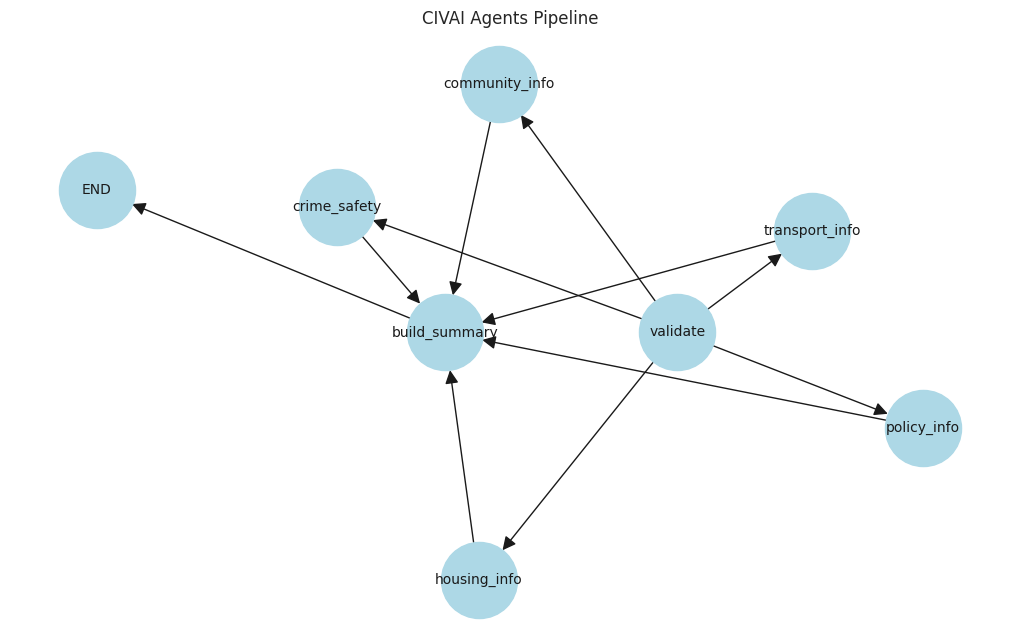

In [259]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
nodes = ["validate", "policy_info", "housing_info", "crime_safety",
         "transport_info", "community_info", "build_summary", "END"]
G.add_nodes_from(nodes)

# Add edges
edges = [
    ("validate", "policy_info"),
    ("validate", "housing_info"),
    ("validate", "crime_safety"),
    ("validate", "transport_info"),
    ("validate", "community_info"),
    
    ("policy_info", "build_summary"),
    ("housing_info", "build_summary"),
    ("crime_safety", "build_summary"),
    ("transport_info", "build_summary"),
    ("community_info", "build_summary"),
    
    ("build_summary", "END")
]
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(10,6))
pos = nx.spring_layout(G, seed=42)  # layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, arrowsize=20, font_size=10)
plt.title("CIVAI Agents Pipeline")
plt.show()
